In [29]:
!pip install tensorflow opencv-python matplotlib tf2onnx


[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [31]:
data = tf.keras.utils.image_dataset_from_directory('dataset')
print(str(len(list(data))) + " batches")

Found 693 files belonging to 2 classes.
22 batches


--------------
**Get a single batch and plot the figures.**

In [32]:
data_iterator = data.as_numpy_iterator()

In [33]:
batch = data_iterator.next()

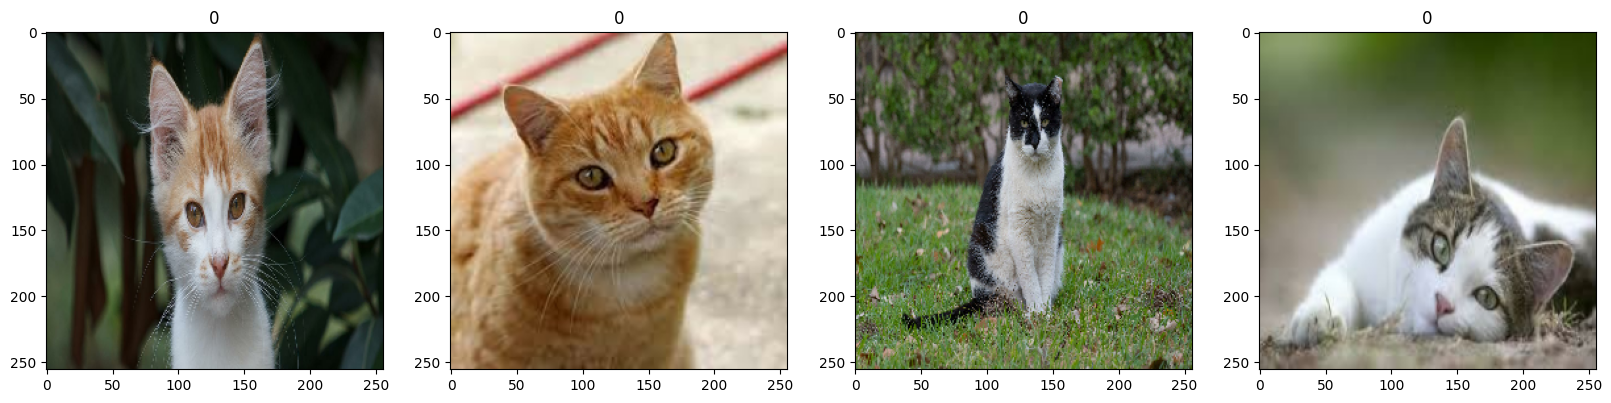

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

--------------
**Scale data**

In [35]:
data = data.map(lambda x,y: (x/255, y))

--------------
**Split data**

In [36]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [37]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

--------------
**Build model**

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [39]:
model = Sequential()

In [40]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [41]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

--------------
**Training**

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
15/15 [==============================] - 4s 196ms/step - loss: 0.9581 - accuracy: 0.4792 - val_loss: 0.6935 - val_accuracy: 0.4844
Epoch 2/20
15/15 [==============================] - 3s 186ms/step - loss: 0.6926 - accuracy: 0.4979 - val_loss: 0.6893 - val_accuracy: 0.6484
Epoch 3/20
15/15 [==============================] - 3s 189ms/step - loss: 0.6844 - accuracy: 0.5854 - val_loss: 0.6778 - val_accuracy: 0.5469
Epoch 4/20
15/15 [==============================] - 3s 194ms/step - loss: 0.6814 - accuracy: 0.5333 - val_loss: 0.6614 - val_accuracy: 0.6719
Epoch 5/20
15/15 [==============================] - 3s 188ms/step - loss: 0.6461 - accuracy: 0.6292 - val_loss: 0.6465 - val_accuracy: 0.6172
Epoch 6/20
15/15 [==============================] - 3s 193ms/step - loss: 0.5782 - accuracy: 0.6917 - val_loss: 0.5556 - val_accuracy: 0.7500
Epoch 7/20
15/15 [==============================] - 3s 186ms/step - loss: 0.5023 - accuracy: 0.7521 - val_loss: 0.4463 - val_accuracy: 0.8125
Epoch 

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

--------------
**Evaluation**

In [ ]:
import cv2

In [ ]:
img = cv2.imread('dataset/dogs/dog_109.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

--------------
**Save model**

In [ ]:
from tensorflow.keras.models import load_model
import tf2onnx
import onnx
import os

In [ ]:
model.save(os.path.join('models','imageclassifier.keras'))

In [ ]:
loaded_model = load_model('models/imageclassifier.keras')

In [ ]:
input_signature = [tf.TensorSpec(loaded_model.inputs[0].shape, loaded_model.inputs[0].dtype, name='digit')]
onnx_model, _ = tf2onnx.convert.from_keras(loaded_model, input_signature, opset=13)

In [ ]:
onnx.save(onnx_model, 'models/imageclassifier.onnx')